In [5]:
import os
import nltk
import random as rand
from tqdm import tqdm, trange
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from classifier import BertClassifier

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Model Utils

In [7]:
model_options = {
    "biobert": "dmis-lab/biobert-v1.1",
    "pubmed_abstract": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
    "scibert": "allenai/scibert_scivocab_uncased",
    "pubmed_fulltext": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    "medbert": "Charangan/MedBERT",
    "basebert": "bert-base-uncased",
    "tinybert": "prajjwal1/bert-tiny",
    "minibert": "prajjwal1/bert-mini",
    "smallbert": "prajjwal1/bert-small",
    "mediumbert": "prajjwal1/bert-medium"
}

In [8]:
# pick the model and create the tokenizer
current_model = model_options['biobert']
tokenizer = AutoTokenizer.from_pretrained(current_model)

In [9]:
labels = {'Excluded':0,
          'Included':1,
          }

In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                      return_tensors="pt") for text in df['titleabstract']]

    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)

        return batch_texts

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Evaluation

In [13]:
model = BertClassifier(hidden=768, model_type=current_model);

In [17]:
state_dict = torch.load("/content/gdrive/MyDrive/ESA/Models/biobert0.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
model.to(device);

In [19]:
model.eval();

In [20]:
predict_data = pd.read_csv('/content/gdrive/MyDrive/ESA/data70-10-20/cns_test.csv')

In [21]:
test = Dataset(predict_data)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

In [22]:
torch.cuda.empty_cache()

In [23]:
full_output = []

for train_input in test_dataloader:

  mask = train_input['attention_mask'].to(device)
  input_id = train_input['input_ids'].squeeze(1).to(device)

  output, attentions = model(input_id, mask)
  full_output.append(output[:].detach().cpu().numpy())

<ipython-input-11-aab93984ddec>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_layer = self.softmax(linear_output)


In [24]:
import itertools
all_logits = []
for array in full_output:
  all_logits.append(list(np.argmax(array, axis=1)[:]))

all_logits = list(itertools.chain.from_iterable(all_logits))

In [25]:
all_logits = np.array(all_logits)

In [ ]:
all_logits.sum()/999

0.35135135135135137

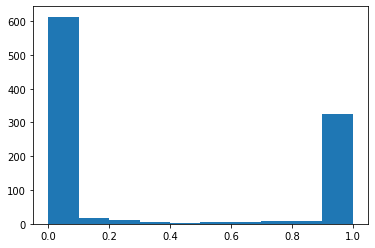

In [26]:
# histogram of prediction probabilities
# import itertools
# out = list(itertools.chain.from_iterable(full_output))
# ones = []
# for i in out:
#   ones.append(i[1])
# plt.hist(ones)
# plt.show() 

In [ ]:
predict_data['Prediction'] = all_logits

In [ ]:
predict_data['Prediction'] = predict_data['Prediction'].replace(0, 'Excluded')
predict_data['Prediction'] = predict_data['Prediction'].replace(1, 'Included')

In [ ]:
predict_data.columns

Index(['Unnamed: 0', 'StudyId', 'Title', 'Authors', 'PublicationName',
       'AlternateName', 'Abstract', 'Url', 'AuthorAddress', 'Year', 'Doi',
       'ReferenceType', 'Keywords', 'PdfRelativePath', 'CustomId',
       'DateTimeCreated', 'SystematicSearchId', 'SystematicSearchName',
       'Reconciled', 'InvestigatorIds', 'InvestigatorNames',
       'ScreeningDecisions', 'ScreeningStatus', 'Decision', 'TitlePred',
       'AbstractPred', 'titleabstract', 'Prediction'],
      dtype='object')

In [ ]:
to_save = predict_data

In [ ]:
to_save.to_csv('cns_1k.csv')

In [ ]:
!cp 'cns_1k.csv' -d '/content/gdrive/MyDrive/ESA/'